In [1]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding
from keras.layers import SpatialDropout1D, Conv1D, GlobalMaxPooling1D # new! 
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# output directory name:
output_dir = 'model_output/conv'

# training:
epochs = 4
batch_size = 128

# vector-space embedding: 
n_dim = 64
n_unique_words = 5000 
max_review_length = 400
pad_type = trunc_type = 'pre'
drop_embed = 0.2 # new!

# convolutional layer architecture:
n_conv = 256 # filters, a.k.a. kernels
k_conv = 3 # kernel length

# dense layer architecture: 
n_dense = 256
dropout = 0.2

### Load Data

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip

17465344/17464789 [==============================] - 5s 0us/step


### Preprocess Data

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

### Design Neural Network Architecture

In [5]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(Conv1D(n_conv, k_conv, activation='relu'))
# model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

In [6]:
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 64)           320000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 400, 64)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 398, 256)          49408     
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2

### Configure the model

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Train the Model

In [9]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/4
196/196 [==============================] - 93s 474ms/step - loss: 0.4886 - accuracy: 0.7379 - val_loss: 0.2936 - val_accuracy: 0.8738
Epoch 2/4
196/196 [==============================] - 95s 483ms/step - loss: 0.2448 - accuracy: 0.9021 - val_loss: 0.2598 - val_accuracy: 0.8930
Epoch 3/4
196/196 [==============================] - 93s 472ms/step - loss: 0.1669 - accuracy: 0.9384 - val_loss: 0.2963 - val_accuracy: 0.8821
Epoch 4/4
196/196 [==============================] - 96s 488ms/step - loss: 0.1140 - accuracy: 0.9605 - val_loss: 0.2926 - val_accuracy: 0.8919


### Evaluate the Model

In [10]:
model.load_weights(output_dir+"/weights.03.hdf5") 

In [11]:
y_hat = model.predict_proba(x_valid)

Instructions for updating:
Please use `model.predict()` instead.


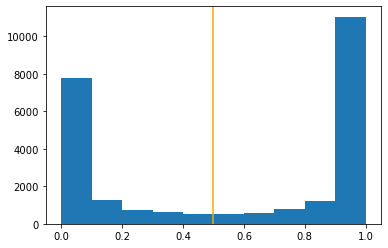

In [12]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [13]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'96.04'